In [13]:
import sys
sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
#from bearinmind_pipeline import data_preprocessing, model_construction, results_blend
import gc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

In [56]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
mapping = pd.read_csv('data/building_metadata.csv')
weather_train = pd.read_csv('data/weather_train.csv')
weather_test = pd.read_csv('data/weather_test.csv')

In [57]:
df_train = df_train.merge(mapping, how = "left", on = "building_id")
df_test = df_test.merge(mapping, how = "left", on = "building_id")

In [58]:
df_train = df_train.merge(weather_train, how = "left", on = ["site_id", "timestamp"])
df_test = df_test.merge(weather_test, how = "left", on =  ["site_id", "timestamp"])

In [59]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.000,nan,25.000,6.000,20.000,nan,1019.700,0.000,0.000
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.000,nan,25.000,6.000,20.000,nan,1019.700,0.000,0.000
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.000,nan,25.000,6.000,20.000,nan,1019.700,0.000,0.000
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.000,nan,25.000,6.000,20.000,nan,1019.700,0.000,0.000
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.000,nan,25.000,6.000,20.000,nan,1019.700,0.000,0.000


In [77]:
df_train_site11 = df_train[(df_train["building_id"] == 1029) & (df_train["meter"] == 3)] 

In [61]:
    df_train_site11["timestamp"] = pd.to_datetime(df_train_site11["timestamp"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
df_train_site11["air_temperature"] = df_train_site11["air_temperature"].fillna(df_train_site11["air_temperature"].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:
df_train_site11["dew_temperature"] = df_train_site11["dew_temperature"].fillna(df_train_site11["dew_temperature"].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [149]:
df_train_site11["sea_level_pressure"] = df_train_site11["sea_level_pressure"].fillna(df_train_site11["sea_level_pressure"].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [170]:
df_train_site11["wind_direction"] = df_train_site11["wind_direction"].fillna(df_train_site11["wind_direction"].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [185]:
df_train_site11["wind_speed"] = df_train_site11["wind_speed"].fillna(df_train_site11["wind_speed"].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [171]:
df_train_site11.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1424,1029,3,2016-01-01 00:00:00,140.929,11,Education,152559,nan,nan,-1.800,nan,-3.200,nan,1016.000,280.000,1.500
3720,1029,3,2016-01-01 01:00:00,147.822,11,Education,152559,nan,nan,-1.700,nan,-2.800,nan,1016.100,260.000,1.000
6016,1029,3,2016-01-01 02:00:00,146.795,11,Education,152559,nan,nan,-2.700,nan,-3.300,nan,1015.800,350.000,0.500
8315,1029,3,2016-01-01 03:00:00,147.235,11,Education,152559,nan,nan,-2.300,nan,-3.200,nan,1015.400,280.000,1.500
10610,1029,3,2016-01-01 04:00:00,145.769,11,Education,152559,nan,nan,-2.600,nan,-3.300,nan,1015.100,310.000,2.100


In [183]:
df_train_site11["wind_speed"].isnull().sum()

170

In [251]:
df_train_site11["wind_speed"].count()

8775

In [ ]:
plt.plot(df_train_site11["timestamp"], df_train_site11["meter_reading"])

In [252]:
train_df = df_train_site11[["timestamp", "meter_reading", 
                            "air_temperature", 
                            "dew_temperature", 
                            "sea_level_pressure", 
                            "wind_direction", 
                            "wind_speed"
                           ]]
#.iloc[0:7000]
valid_df = df_train_site11[["timestamp", "meter_reading", 
                           "air_temperature", 
                           "dew_temperature",
                           "sea_level_pressure", 
                           "wind_direction",
                           "wind_speed"
                           ]]
#.iloc[7000:8775]

In [253]:
train_df.columns = ["ds", "y", "air_temperature", 
                    "dew_temperature", 
                    "sea_level_pressure",
                    "wind_direction", 
                    "wind_speed"
                   ]
valid_df.columns = ["ds", "y", "air_temperature", 
                    "dew_temperature", 
                    "sea_level_pressure",
                   "wind_direction", 
                    "wind_speed"
                   ]

In [258]:
z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
           seasonality_mode = 'multiplicative')
z.add_regressor('air_temperature')
z.add_regressor('dew_temperature')
z.add_regressor('sea_level_pressure')
z.add_regressor('wind_direction')
z.add_regressor('wind_speed')
z.add_seasonality(name='hourly', period=24, fourier_order=2)
z.add_seasonality(name='monthly', period=30.5, fourier_order=5)
z.fit(train_df)

In [ ]:
#df_cv = cross_validation(z, initial='2160 hours', period='720 hours', horizon = '1440 hours')
#df_p = performance_metrics(df_cv)
#df_p

In [ ]:
#rmsle(y = df_cv["y"], yhat= df_cv["yhat"])

In [245]:
forecast = z.predict(valid_df[["ds", "air_temperature", 
                               "dew_temperature", 
                               "sea_level_pressure",
                               "wind_direction", 
                               "wind_speed"
                              ]])

In [246]:
forecast.head()

,ds,y,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
16071894,2016-10-19 00:00:00,36.222,21.100,17.100,1000.600,230.000,5.100
16074230,2016-10-19 01:00:00,83.150,20.300,16.800,1001.800,270.000,4.100
16076567,2016-10-19 02:00:00,39.449,18.800,14.200,1003.300,300.000,6.200
16078905,2016-10-19 03:00:00,15.838,16.500,10.000,1004.800,290.000,4.600
16081243,2016-10-19 04:00:00,22.877,14.400,9.000,1005.900,300.000,3.100


In [247]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,air_temperature,air_temperature_lower,air_temperature_upper,daily,daily_lower,daily_upper,dew_temperature,dew_temperature_lower,dew_temperature_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,hourly,hourly_lower,hourly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sea_level_pressure,sea_level_pressure_lower,sea_level_pressure_upper,weekly,weekly_lower,weekly_upper,wind_direction,wind_direction_lower,wind_direction_upper,wind_speed,wind_speed_lower,wind_speed_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-10-19 00:00:00,29.634,-28.994,70.075,29.634,29.634,-0.291,-0.291,-0.291,-0.079,-0.079,-0.079,-0.059,-0.059,-0.059,-0.310,-0.310,-0.310,0.035,0.035,0.035,-0.321,-0.321,-0.321,0.009,0.009,0.009,0.033,0.033,0.033,0.005,0.005,0.005,0.026,0.026,0.026,0.000,0.000,0.000,20.116
1,2016-10-19 01:00:00,29.650,-26.946,64.719,29.650,29.650,-0.271,-0.271,-0.271,-0.122,-0.122,-0.122,-0.058,-0.058,-0.058,-0.294,-0.294,-0.294,0.034,0.034,0.034,-0.351,-0.351,-0.351,0.008,0.008,0.008,0.031,0.031,0.031,0.015,0.015,0.015,0.011,0.011,0.011,0.000,0.000,0.000,19.237
2,2016-10-19 02:00:00,29.665,-25.215,70.167,29.665,29.665,-0.232,-0.232,-0.232,-0.130,-0.130,-0.130,-0.047,-0.047,-0.047,-0.206,-0.206,-0.206,0.034,0.034,0.034,-0.273,-0.273,-0.273,0.007,0.007,0.007,0.029,0.029,0.029,0.022,0.022,0.022,0.043,0.043,0.043,0.000,0.000,0.000,21.562
3,2016-10-19 03:00:00,29.680,-26.064,70.622,29.680,29.680,-0.173,-0.173,-0.173,-0.114,-0.114,-0.114,-0.029,-0.029,-0.029,-0.157,-0.157,-0.157,0.033,0.033,0.033,-0.210,-0.210,-0.210,0.006,0.006,0.006,0.027,0.027,0.027,0.020,0.020,0.020,0.019,0.019,0.019,0.000,0.000,0.000,23.443
4,2016-10-19 04:00:00,29.695,-23.947,74.377,29.695,29.695,-0.119,-0.119,-0.119,-0.083,-0.083,-0.083,-0.025,-0.025,-0.025,-0.120,-0.120,-0.120,0.033,0.033,0.033,-0.145,-0.145,-0.145,0.006,0.006,0.006,0.025,0.025,0.025,0.022,0.022,0.022,-0.004,-0.004,-0.004,0.000,0.000,0.000,25.388


In [248]:
def rmsle(y, yhat):
    score = np.sqrt(np.mean(np.power(np.log(yhat+1)-np.log(y.reset_index(drop=True)+1), 2)))
    return(score)

In [249]:
rmsle(y = valid_df["y"], yhat= forecast["yhat"])

0.9730242504161175

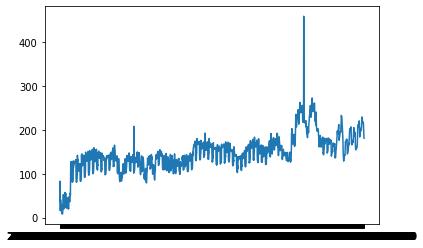

In [223]:
plt.plot(valid_df["ds"], valid_df["y"])

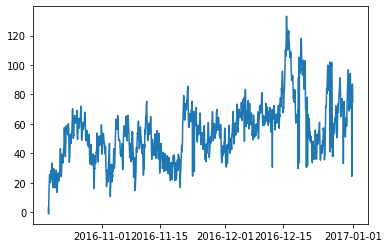

In [224]:
plt.plot(forecast["ds"], forecast["yhat"])

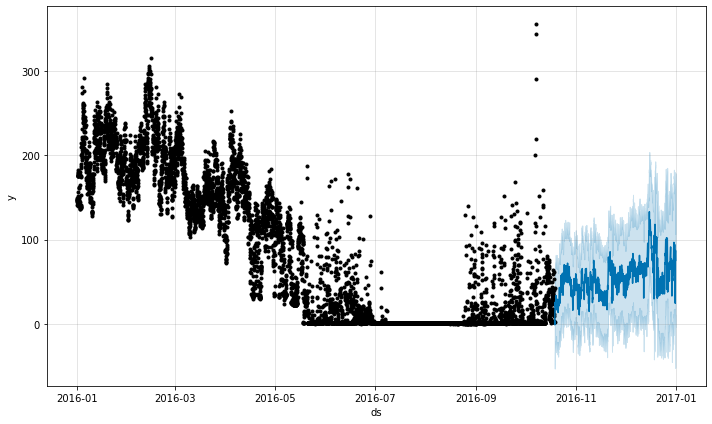

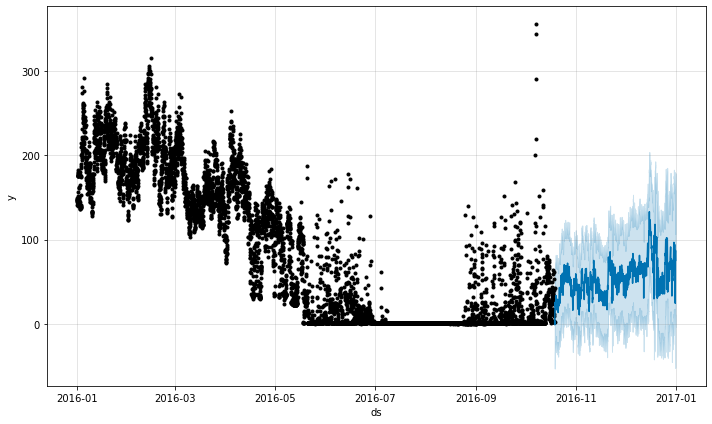

In [225]:
z.plot(forecast,
              uncertainty=True)

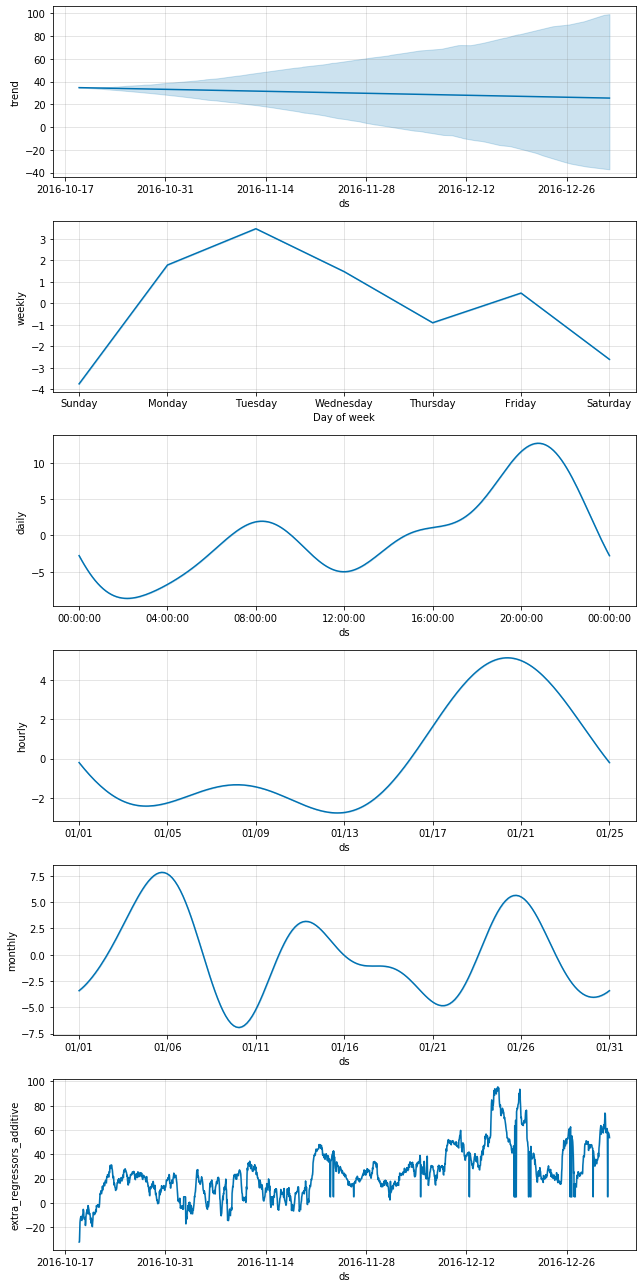

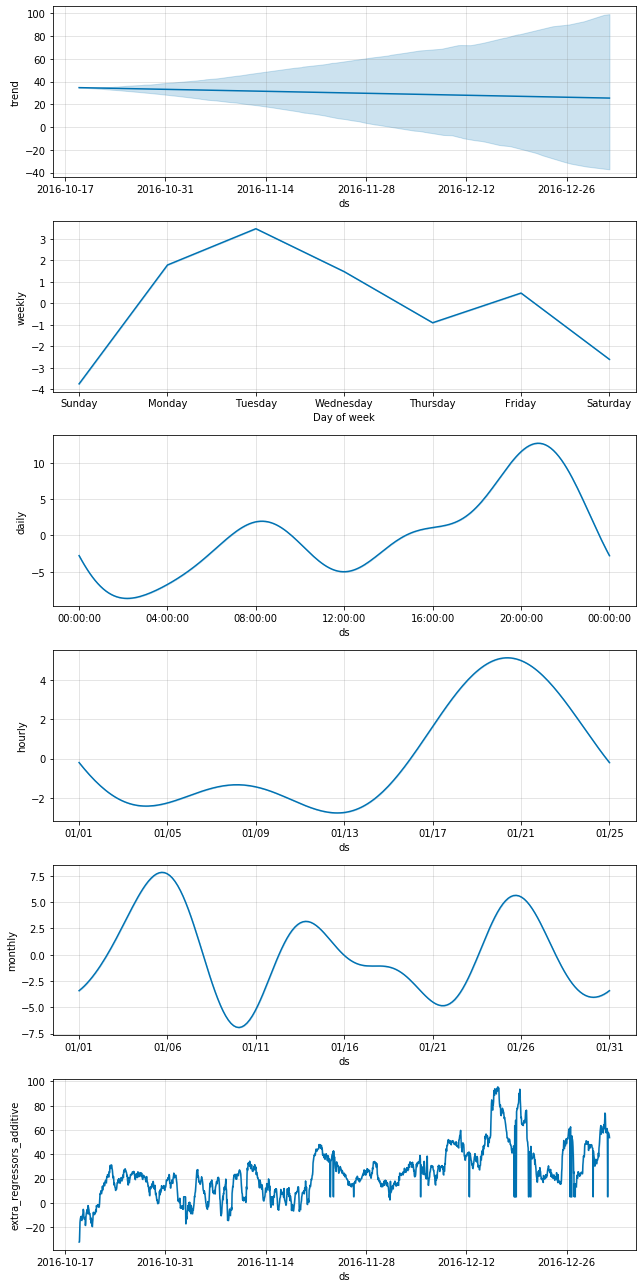

In [226]:
z.plot_components(forecast)

In [227]:
gc.collect()

37

In [4]:
df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [5]:
### Drop zero values in Electricity ###
df_train = df_train.drop(df_train[(df_train['meter'] == 0) 
                       & (df_train['meter_reading'] == 0.0)].index)

In [6]:
def roll_diff(x):
    return x[-1] - x[0]

In [7]:
def check_constants(grp):
    grp['is_constant_meter'] = grp['meter_reading'].rolling(2).apply(roll_diff)
    return grp

In [8]:
#df_train = df_train.groupby(['building_id', 'meter'], as_index = False).apply(lambda x: check_constants(x))

In [9]:
#df_train = df_train.drop(['is_constant_meter'])

KeyError: "['is_constant_meter'] not found in axis"

In [ ]:
#df_train.loc[df_train['is_constant_meter'] == 0.0, 'meter_reading'] = np.nan

In [ ]:
#def rolling_interpol(df):
#    roll_wind = df['meter_reading'].isnull().sum()
#    if roll_wind == 0:
#        pass
#    else:
#        df['meter_reading'] = df.meter_reading.fillna(df.meter_reading.rolling(roll_wind, min_periods=1).mean())
#    return df

In [ ]:
#df_train = df_train.groupby(['building_id', 'meter']).apply(lambda x : rolling_interpol(x))

In [ ]:
#df_train['meter_reading'] = df_train.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [10]:
df_train[(df_train['site_id'] == 0) & (df_train['meter'] == 1)]['building_id'].unique()

array([  7,   9,  13,  14,  15,  29,  30,  31,  43,  50,  55,  60,  75,
        76,  78,  82,  91,  92,  95,  96,  97, 103,  28,  98])

In [11]:
test = df_train[(df_train['meter'] == 0) & (df_train['site_id'] == 1)] 

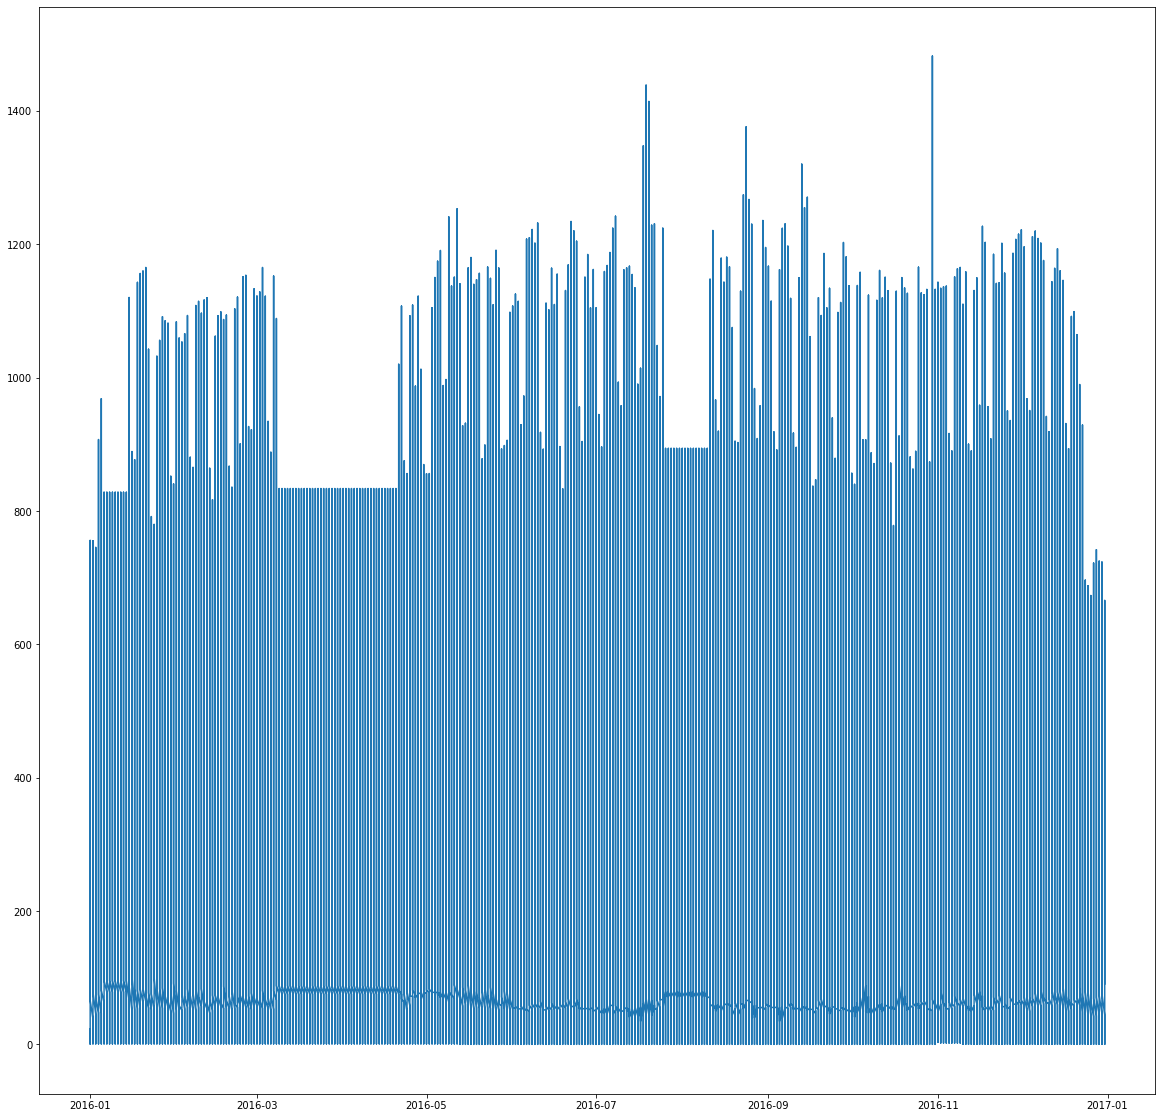

In [12]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(test["timestamp"]).dt.date, test['meter_reading'])

In [14]:
x_train , x_test = train_test_split(test,test_size=0.3) 
X = x_train.drop(['timestamp', 'meter_reading'], axis=1)
Y = x_train['meter_reading']
X_test = x_test.drop(['timestamp', 'meter_reading'], axis=1)
print("Scaling all variables")
X = np.nan_to_num(X)
            
scaler_x = MinMaxScaler()
#scaler_y = MinMaxScaler()
            
scaler_x.fit(X)
X=scaler_x.transform(X)

Y=np.reshape(pd.DataFrame(Y), (-1,1))
#scaler_y.fit(Y)
#Y=scaler_y.transform(Y)
            
scaler_test = MinMaxScaler()
scaler_test.fit(X_test)
X_test = np.nan_to_num(X_test)
X_test=scaler_x.transform(X_test)

Scaling all variables


ValueError: could not convert string to float: 'Lodging/residential'

In [ ]:
fit_model = Sequential()            
fit_model.add(Dense(330, input_dim=330, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(280, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(230, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(180, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(130, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(80, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(60, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(40, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(20, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(16, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(12, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(8, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(5, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(3, kernel_initializer='normal', activation='relu'))
fit_model.add(Dense(1, activation='linear'))